In [1]:
import numpy as np
import control as ct
import scipy as sp
import sys
from functools import partial
import matplotlib.pyplot as plt
print("ENVIRONMENT:",sys.executable)

ENVIRONMENT: /home/cjb/miniconda3/envs/ctrl2/bin/python


Utils

In [160]:
def controllability(Ai,Bi):
    ni = Ai.shape[0]
    ri = Bi.shape[1]
    controllability = np.zeros((ni,ni*ri))
    for i in range(ni):
        controllability[:,i*ri:(i+1)*ri] = np.linalg.matrix_power(Ai,i)@Bi
    return controllability
def is_controllable(Ai,Bi):
    # never gives false positives, only false negatives
    ni = Ai.shape[0]
    return np.linalg.matrix_rank(controllability(Ai,Bi)) == ni
def diagonalize(Ai):
    E,V = np.linalg.eig(Ai)
    return np.diag(E), V
def exp_diag(Ai): # TODO assumes fully diagonal https://math.stackexchange.com/questions/1451276/matrix-exponential-for-jordan-canonical-form
    return np.diag(np.exp(np.diagonal(Ai)))
def rk4_ctrl(xvec, uvec,fun, dti): # TODO enable multistep uvec
    k1 = dti*fun(xvec,uvec)
    k2 = dti*fun(xvec+k1/2.,uvec)
    k3 = dti*fun(xvec+k2/2.,uvec)
    k4 = dti*fun(xvec+k3,uvec)
    xvec += 1./6*(k1+2*k2+2*k3+k4)
    return xvec
def exp_mat_t(MDi,MUi,ti):
    return MUi@(exp_diag(MDi*ti)@np.conj(MUi.T))
def lti_prop(ADi,AUi,Bi,xi_0,u_t,t_t): # u_t is r x len(t_t0
    ni = len(xi_0)
    nt = len(t_t)
    out = np.zeros((ni,nt)) # assumes flat
    eAt_t = np.zeros((ni,ni,nt))
    integrand_t = np.zeros((ni,nt))
    for i,ti in enumerate(t_t): # TODO:speedup
        eAt_t[:,:,i] = exp_mat_t(ADi,AUi,ti) # todo better precompile by using e^{A(t + s)} = e^{At}e^{As}
        integrand_t[:,i] = 0 # TODO
        control_part = 0 # TODO
        return eAt_t[:,:,i]@(xi_0 + control_part)
def dx_dt(Ai,Bi,xi,ui):
    return Ai@xi + Bi@ui
def obs(Ci,Di,xi,ui):
    return Ci@xi + Di@ui

In [3]:
print("Controllability Working?")
A = np.array([[1,1],[0,-1]])
B = np.array([[1],[0]]) # not
print(is_controllable(A,B)==False)
A = np.array([[1,1],[2,-1]])
B = np.array([[0],[1]])
print(is_controllable(A,B)==True) #yes
print("Diagonalization Working?")
D,U = diagonalize(A)
print(np.allclose(exp_diag(D),np.diag(np.array([np.exp(np.sqrt(3)),np.exp(-np.sqrt(3))]))))

Controllability Working?
True
True
Diagonalization Working?
True


In [191]:
def control_lti(Ai,Bi,xi_0,ui_xt,ti,Ci=None,Di=None):
    ni = Ai.shape[0]
    ri = Bi.shape[1]
    do_obs = True
    ki = 0
    if Ci is None:
        do_obs = False
    else:
        ki = Ci.shape[0]
    dx_dt_lti = partial(dx_dt,Ai,Bi)
    if do_obs:
        obs_lti = partial(obs,Ci,Di)
    print(f"Dimensions:\nA={Ai.shape[0]}x{Ai.shape[1]}\nB={Bi.shape[0]}x{Bi.shape[1]}")
    if do_obs:
        print(f"Obvervation Dimensions:\nC={Ci.shape[0]}x{Ci.shape[1]}\nD={Di.shape[0]}x{Di.shape[1]}\n")
    print(f"Controllable?: {is_controllable(Ai,Bi)}")
    Nti = len(ti)
    dti = ti[1]-ti[0]
    xi_t = np.zeros((ni,Nti),dtype=complex)
    xi_t[:,0] = xi_0 # theta, thetadot, x, xdot
    if do_obs:
        yi_t = np.zeros((ki,Nti))
        yi_t[:,0] = obs_lti(xi_t[:,0],ui_x(xi_0))
    print(fr"Running LTI Control: N_t={Nti}, delta_t={np.round(dti,3)}, x_0={xi_0}")
    for i in range(1,Nti):
        ui_ti = ui_xt(xi_t[:,i-1],ti[i]).flatten()
        xi_t[:,i] = rk4_ctrl(xi_t[:,i-1],ui_ti,dx_dt_lti,dti)
        if do_obs:
            yi_t[:,i] = obs_lti(xi_t[:,i],ui_ti)
    print("LTI Done")
    if do_obs:
        return np.real(xi_t),np.real(yi_t)
    return np.real(xi_t)

### Example Controlling With Parameterized Control Sequences (1D)

In [26]:
a = 1
b = .2
A = np.array([[a]])
B = np.array([[b]])
C = np.eye(1)
D = np.zeros((1,1))
x_0 = np.array([-0.1])
tf = 5
x_f = 10
Nt = 1000
t = np.linspace(0,tf,Nt)

In [27]:
def get_scheme_for_key_1d(key):
    lhs = (x_f-np.exp(a*tf)*x_0)*np.exp(-a*tf)/b
    if key == "cos":
        def optim_omega(omega_i):
            rhs = np.exp(-a*tf)*(-a*np.cos(tf*omega_i)+a*np.exp(a*tf) + omega_i*np.sin(tf*omega_i))/(a**2+omega_i**2)
            return  lhs-rhs
        omega = sp.optimize.fsolve(optim_omega,10)
        print(f"Optimized Omega: {omega}")
        u_t = np.cos(omega*t).reshape(1,Nt)
        return u_t
    elif key == "box": 
        i1 = int(Nt/2.5)
        t1 = t[i1]
        i2 = int(2*Nt/3.)
        t2 = t[i2]
        def optim_height(hi):
            rhs = -hi/a*(np.exp(-a*t2)-np.exp(-a*t1))
            return lhs - rhs
        h = sp.optimize.fsolve(optim_height,2)
        print(f"Optimized Height: {h}")
        u_t = np.zeros((1,Nt))
        u_t[0,i1:i2] = h
        return u_t

THIS IS THE WRONG WAY TO THINK ABOUT CONTROLLING linear time INVARIANT systems by controlling as preset function of time

In [110]:
schemes = ["cos","box"]
u_t = get_scheme_for_key_1d("box")
x_t,y_t = control_lti(A,B,x_0,u_t,t,Ci=C,Di=D)
x_labels=[r"$x$"]
u_labels=[r"$u$"]
fig, ax1 = plt.subplots()
ax1.set_xlabel("Time")
ax1.set_ylabel("$x$")
ax1.set_ylim([-2+np.min(x_t[0,:]),x_f*1.2])
for i_x in range(len(x_labels)):
    ax1.plot(t,x_t[i_x,:],label=x_labels[i_x])
ax2 = ax1.twinx()
ax2.set_ylabel("$u$")
for i_u in range(len(u_labels)):
    ax2.plot(t,u_t[0,:],color='black',label=u_labels[i_u])
# for i_y in range(len(y_labels)):
#     plt.plot(t,y_t[i_y,:],label=y_labels[i_y])
ax1.scatter(tf,x_f,color="red",label="Target")
ax1.scatter(0,x_0,label="Initial")
ax1.legend()
ax2.legend()
plt.title("Controlled")
plt.show()

ValueError: The array returned by a function changed size between calls

### Example with Parameterized Control Sequence (2D)

In [29]:
A = np.array([[1,1],[2,-1]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
D = np.zeros((1,1))
x_0 = np.array([-1,2])
tf = 5
x_f = 10
Nt = 1000
t = np.linspace(0,tf,Nt)

In [30]:
AD,AU = diagonalize(A)
AUi = np.linalg.inv(AU)
print(AD)
print(AU)
print(AU@(AD@AUi))

[[ 1.73205081  0.        ]
 [ 0.         -1.73205081]]
[[ 0.80689822 -0.34372377]
 [ 0.59069049  0.9390708 ]]
[[ 1.  1.]
 [ 2. -1.]]


Dimensions:
A=2x2
B=2x1
Obvervation Dimensions:
C=1x2
D=1x1

Controllable?: True
Running LTI Control: N_t=1000, delta_t=0.005, x_0=[-1  2]
LTI Done
(2, 1000)


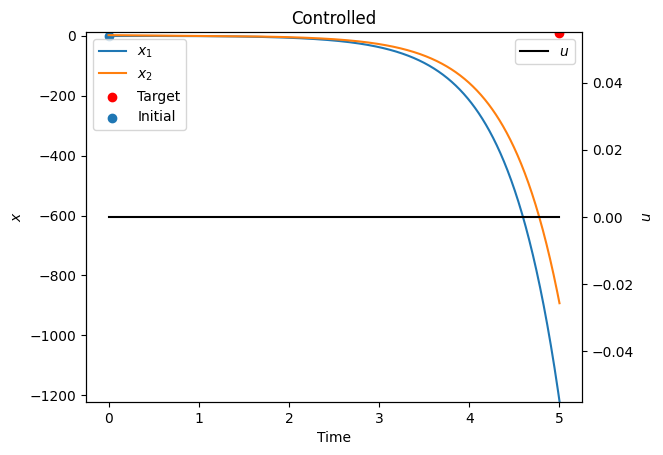

In [31]:
schemes = ["cos","box"]
u_t = np.zeros((1,Nt))
x_t,y_t = control_lti(A,B,x_0,u_t,t,Ci=C,Di=D)
print(x_t.shape)
x_labels=[r"$x_1$",r"$x_2$"]
u_labels=[r"$u$"]
y_labels=[r"y:$x_1$"]
fig, ax1 = plt.subplots()
ax1.set_xlabel("Time")
ax1.set_ylabel("$x$")
ax1.set_ylim([-2+np.min(x_t[0,:]),x_f*1.2])
for i_x in range(len(x_labels)):
    ax1.plot(t,x_t[i_x,:],label=x_labels[i_x])
# for i_y in range(len(y_labels)):
#     ax1.plot(t,y_t[i_y,:],label=y_labels[i_y])
ax2 = ax1.twinx()
ax2.set_ylabel("$u$")
for i_u in range(len(u_labels)):
    ax2.plot(t,u_t[0,:],color='black',label=u_labels[i_u])
# for i_y in range(len(y_labels)):
#     plt.plot(t,y_t[i_y,:],label=y_labels[i_y])
ax1.scatter(tf,x_f,color="red",label="Target")
ax1.scatter(0,x_0[0],label="Initial")
ax1.legend()
ax2.legend()
plt.title("Controlled")
plt.show()

### Cart Pole

In [22]:
M = 100
m = 10
g = .8
l = 2
I = m*l*l
n = 4
A = np.array([[0,1,0,0],[(M+m)*g/M/l,0,0,0],[0,0,0,1],[-m*g/M,0,0,0]])
B = np.array([0,-1/M/l,0,1/M]).reshape(n,1)
C = np.array([[1,0,0,0],[0,0,1,0]])
D = np.zeros((2,1))
x_0 = np.array([.2,0,0,0])
u_0 = np.zeros(1).flatten()
tf = 2
Nt = 1000
u_t = np.tile(u_0,(1,Nt))
t = np.linspace(0,tf,Nt)
x_t,y_t = control_lti(A,B,x_0,u_t,t,Ci=C,Di=D)

x_labels = [r"$\theta$",r"$\dot{\theta}$",r"$x$",r"$\dot{x}$"]
y_labels = [r"y:$\theta$",r"y:$x$"]
for i_x in range(len(x_labels)):
    plt.plot(t,x_t[i_x,:],label=x_labels[i_x])
# for i_y in range(len(y_labels)):
#     plt.plot(t,y_t[i_y,:],label=y_labels[i_y])
plt.legend()
plt.title("Free Motion")
plt.show()

Dimensions:
A=4x4
B=4x1
Obvervation Dimensions:
C=2x4
D=2x1

Controllable?: True


ValueError: could not broadcast input array from shape (2,) into shape (0,)

### 9-6 Controllability/Obvservability + Pole Placement

Controllable Examples

In [192]:
A = np.array([[1,1,6],[4,-1,-6],[0,1,-2]])
n = A.shape[0]
B = np.array([[0],[4],[3]])
C = np.eye(n)
D = np.zeros((n,1))
print("A")
print(A)
print("B")
print(B)
print("Eigvals")
Avals,Avecs= np.linalg.eig(A)
print(Avals)

A
[[ 1  1  6]
 [ 4 -1 -6]
 [ 0  1 -2]]
B
[[0]
 [4]
 [3]]
Eigvals
[ 2.7878631 +0.j         -2.39393155+2.93547246j -2.39393155-2.93547246j]


In [145]:

def get_optimal_gain(Ai,Bi,Ci,Di,target_eigs,verbose=0):
  # M matrix
  M = controllability(Ai,Bi)
  # W matrix
  num,den = sp.signal.ss2tf(Ai,Bi,Ci,Di) # den from polynomial of det(sI-A) = 0
  a = den[1:] # den[0] = 1, den[i] = a_i
  W = np.eye(n)
  for i in range(n-1):
    np.fill_diagonal(W[:-(i+1),(i+1):],a[i])
  W = np.fliplr(W)
  # T Matrix
  T = M@W
  # canonical form
  Ti = np.linalg.inv(T)
  canonical = np.round(Ti@(Ai@T),4)
  # targeting gain matrix
  alpha = np.poly(target_eigs)[1:] # char poly of values
  K = np.flip(alpha-a).reshape((1,n))@Ti
  if verbose > 0:
    print(M.shape)
    print(f"Controllable: {is_controllable(Ai,Bi)}")
    print("M")
    print(M)
    print("a")
    print(a)
    print("W")
    print(W)
    print("T")
    print(T)
    print("canonical A")
    print(canonical)
    print("canonical B")
    print(np.round(Ti@Bi,3))
    print("alpha")
    print(alpha)
    print("Optimal Gain")
    print(K)
  return K.flatten()


In [193]:
print("No Control")
x_0 = np.array([-5,1,6])
N = 1000
t = np.linspace(0,10,N)
u = np.zeros((1,N))
def u_x_none(xi,ti):
  return np.array([0])
x_t_noctrl = control_lti(A,B,x_0,u_x_none,t)
print()
targets = np.array([-5,-.5+.5j,-.5-.5j])
K = get_optimal_gain(A,B,C,D,targets)
print(f"Poles Placed at {targets}: Gain={K}")
actualeigs,actualvecs= np.linalg.eig(A-B@K.reshape(1,n)) # verifies actually worked
print(f"Gain Proper? {np.allclose(sorted(targets),sorted(actualeigs))}")
def u_x_opt(xi,ti):
  return np.array([np.dot(xi,-K)])
u = np.tile(u_0,(1,N))
x_t_optgain = control_lti(A,B,x_0,u_x_opt,t)

No Control
Dimensions:
A=3x3
B=3x1
Controllable?: True
Running LTI Control: N_t=1000, delta_t=0.01, x_0=[-5  1  6]
LTI Done

Poles Placed at [-5. +0.j  -0.5+0.5j -0.5-0.5j]: Gain=[0.41006711 0.50973154 0.65369128]
Gain Proper? True
Dimensions:
A=3x3
B=3x1
Controllable?: True
Running LTI Control: N_t=1000, delta_t=0.01, x_0=[-5  1  6]
LTI Done


Uncontrolled matrix unstable


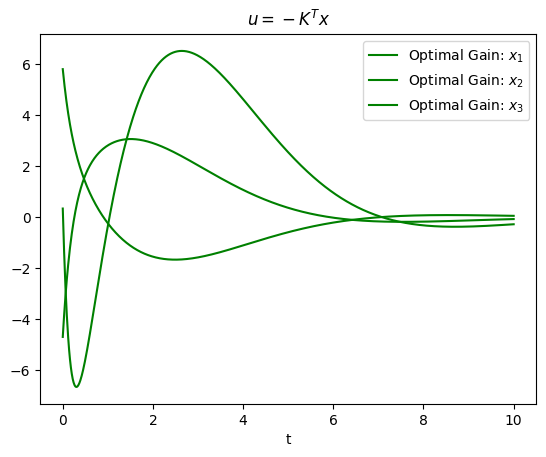

In [195]:
if np.all(np.real(Avals) < 0):
  x_labels_noctrl = [r"No Control: $x_1$",r"No Control: $x_2$",r"No Control: $x_3$"]
  for i,xlab in enumerate(x_labels_noctrl):
    plt.plot(t,x_t_noctrl[i,:],label=xlab,color='blue')
else:
  print("Uncontrolled matrix unstable")

x_labels_opt_gain = [r"Optimal Gain: $x_1$",r"Optimal Gain: $x_2$",r"Optimal Gain: $x_3$"]
for i,xlab in enumerate(x_labels_opt_gain):
  plt.plot(t,x_t_optgain[i,:],label=xlab,color='green')
plt.legend()
plt.xlabel("t")
plt.title("$u = -K^Tx$")
plt.show()